# Reasoning with Large Language Models, a Survey
Aske Plaat, Annie Wong, Suzan Verberne, Joost Broekens,
Niki van Stein, Thomas Bäck LIACS, Leiden University, Netherlands
(July 16, 2024)

**Chain of thought prompting (CoT)** - это метод, который расширяет возможности рассуждений больших языковых моделей (LLM) путем включения логических шагов — или «цепочки мыслей» — в промпт.

В отличие от подсказок с прямым ответом, CoT направляет модель на прохождение промежуточных шагов рассуждения.

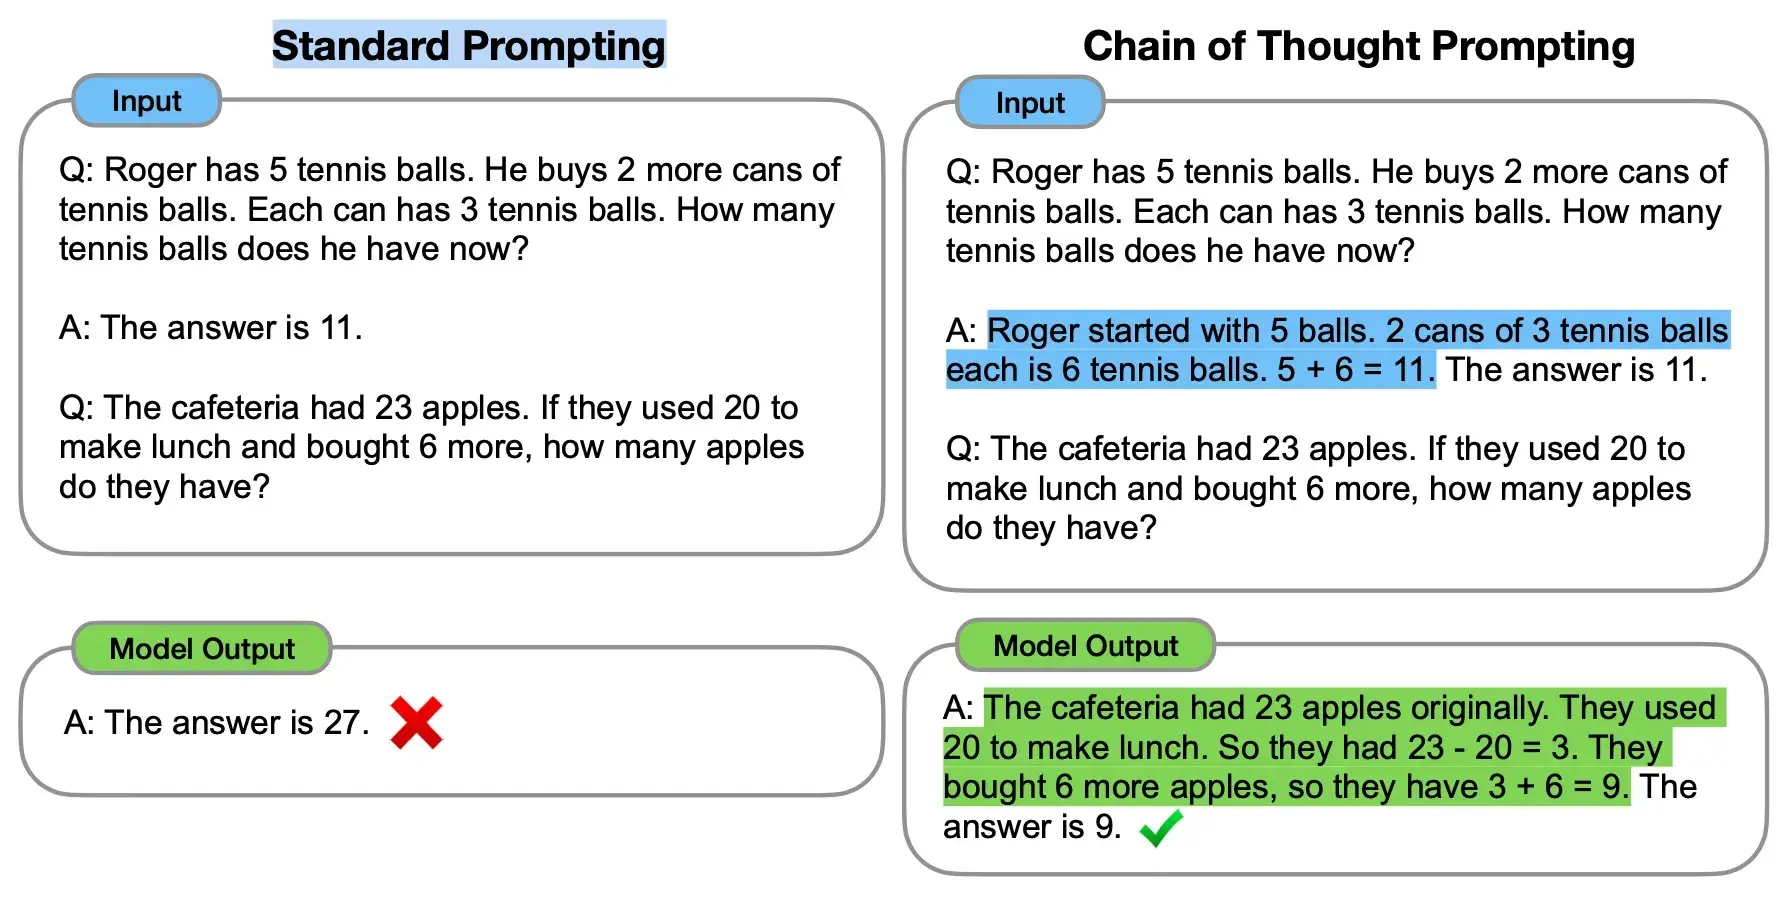

## Стандартный пайплайн обучения модели
- Сбор данных : Получение большого качественного объема текстов.
- Предобучение : Обучение трансформерной модели на этих текстах без учителя.
- Файнтюнинг : Обучение предобученной модели на специфической задаче с использованием данных с метками.
-  Настройка инструкций улучшение модели на размеченно наборе данных с инструкциями и соответствующими выходными данных для улучшения следования инструкциям и, следовательно, повышения полезности моделей.
- Выравнивание с ожиданиями пользователей : Улучшение этического и социального качества ответов модели.
- Оптимизация обучения : Улучшение эффективности обучения с использованием различных методов, таких как низкоранговая оптимизация, тренировка с использованием смешанной точности, квантизация и дистилляция знаний.
- In-context learning : Используются промпты с примерами или инструкциями. Промпты содержат контекст, который помогает модели выбрать правильный ответ.

## Reasoning Pipline
- Генерация : Создание шагов решения задачи моделью.
- Оценка : Проверка и оценка предсказанных шагов моделью.
- Контроль : Управление количеством шагов и глубиной рассуждения.

## Бенчмарки

### GSM8K
До введения метода Chain-of-thought модели языка показывали слабые результаты на этом датасете, достигая точности 15,6% (GPT-3 175B), в то время как Chain-of-thought повышает точность до 46,9%.

###ASDi
GPT-3 175B показывает точность 70,3%, а метод Chain-of-thought — 71,3%.

###AQuA
Точность GPT-3 175B составляет 24,8%, а Chain-of-thought — 35,8%.

In [ ]:
# Импорт библиотек
from openai import OpenAI

In [ ]:
# Небольшие датасеты для тестирования

# Математические задачи
math_tasks = [
    {"task": "Химик Наташа смешала 10-процентный и 20-процентный растворы спирта. Она знает, что если добавит к смеси 1 литр чистой воды, то получит 14-процентный раствор спирта. С другой стороны, если она добавит вместо 1 литра воды 1 литр 40-процентного раствора спирта, то получит 22-процентный раствор спирта. Сколько литров 10-процентного раствора спирта смешала Наташа?", "answer": "1"},
    {"task": "Свежие грибы содержат 90% воды, а сухие грибы – 12% воды. Сколько получится сухих грибов из 11 кг свежих?", "answer": "1,25"},
    {"task": "Фермер отправился на машине в город, находящийся на расстоянии 110 км от фермы. Через 20 минут из города на ферму выехал его сын, который проезжал в час на 5 км больше. Встреча произошла в 50 км от города. С какой скоростью ехал фермер?", "answer": "45"},
    {"task": "Бассейн наполнится. Если первую трубу открыть на 12 минут, а вторую – на 7 минут. Если же обе трубы открыть на 6 минут. То наполнится 2/3 бассейна. За сколько минут наполнится бассейн, если открыть только вторую трубу?", "answer": "15"},
    {"task": "Клиент взял в банке кредит 12000 рублей на год под 16%. Он должен погашать кредит, внося в банк ежемесячно одинаковую сумму денег, с тем чтобы через год выплатить всю сумму, взятую в кредит, вместе с процентами. Сколько рублей он должен вносить в банк ежемесячно?", "answer": "1160"},
    {"task": "Грузовик перевозит партию щебня массой 210 тонн, ежедневно увеличивая норму перевозки на одно и то же число тонн. Известно, что за первый день было перевезено 2 тонны щебня. Определите, сколько тонн щебня было перевезено за девятый день, если вся работа была выполнена за 14 дней.", "answer": "18"},
    {"task": "Игорь и Паша красят забор за 24 часа. Паша и Володя красят этот же забор за 35 часов, а Володя и Игорь — за 40 часов. За сколько часов мальчики покрасят забор, работая втроем?", "answer": "21"},
    {"task": "Теплоход проходит по течению реки до пункта назначения 255км и после стоянки возвращается в пункт отправления. Найдите скорость теплохода в неподвижной воде, если скорость течения равна 1км/ч, стоянка длится 2 часа, а в пункт отправления теплоход возвращается через 34 часа после отплытия из него. Ответ дайте в км/ч.", "answer": "16"},
    {"task": "Васе надо решить 98 задач. Ежедневно он решает на одно и то же количество задач больше по сравнению с предыдущим днём. Известно, что за первый день Вася решил 8 задач. Определите, сколько задач решил Вася в последний день, если со всеми задачами он справился за 7 дней.", "answer": "20"},
    {"task": "Оптовая цена учебника 170 рублей. Розничная цена на 20% выше оптовой. Какое наибольшее число таких учебников можно купить по розничной цене на 7000 рублей?", "answer": "34"}
]

# Логические задачи
logic_tasks = [
    {"task": "Арташ, Отар, Гурам и Сурен занимаются в разных спортивных секциях. Один из них играет в баскетбол, другой – в волейбол, третий – в футбол, четвертый – в теннис. У них различные увлечения: один из них любит кино, другой – театр, третий – эстраду, а четвертый – цирк. Арташ не играет ни в волейбол, ни в баскетбол. Отар играет в футбол и любит театр. Сурен не играет в волейбол. Тот из ребят, кто играет в волейбол, любит ходить в кино, а тот, кто играет в баскетбол, не любит цирк. Каким видом спорта занимается Сурен", "answer": "баскетбол"},
    {"task": "В бутылке, стакане, кувшине и банке находятся молоко, лимонад, квас и вода. Известно, что вода и молоко не в бутылке, сосуд с лимонадом стоит между кувшином и сосудом с квасом, в банке – не лимонад и не вода. Стакан стоит около банки и сосуда с молоком. В каком сосуде налит квас?", "answer": "банка"},
    {"task": "Три подруги вышли в белом, зеленом и синем платьях. Их туфли тоже были белого, зеленого и синего цветов. Известно, что только у Ани цвет платья и туфель совпадали. Ни платье, ни туфли Вали не были белыми, Наташа была в зеленых туфлях. Какой цвет туфель у Ани", "answer": "белый"},
    {"task": "После традиционного вечера встречи с бывшими выпускниками школы в стенгазете появилась заметка о трех бывших учениках школы. В этой заметке было написано, что Иван, Борис и Андрей стали учителями. Теперь они преподают разные дисциплины: один – математику, второй – физику, третий – химию. Живут они тоже в разных городах: Минске, Витебске и Харькове. В заметке было еще написано, что первоначальные их планы осуществились не полностью: Иван работает не в Минске, Андрей – не в Витебске; житель Минска преподает не математику, Андрей преподает не физику. Повезло только жителю Витебска: он преподает любимую им химию. Как зовут жителя Витебска?", "answer": "Иван"},
    {"task": "На математическую олимпиаду в город Киров поехало четыре девятиклассника: Лева, Коля, Миша и Петя. В первый день они решили позавтракать в разных местах: один пошел в кафе, другой – в столовую, третий – в закусочную, четвертый – в буфет. После завтрака они снова собрались вместе. Разговор, естественно, зашел о том, кто как позавтракал. Выяснилось, что все они пили разные напитки, так как в каждом из этих мест, где они завтракали, оказалось в наличии только по одному напитку: в одном месте – только кофе, в другом – только молоко, в третьем – только ряженка, в четвертом – только чай. В буфете, например, было только молоко, а в столовой не было ряженки. Петя рассказал, что он был в столовой, но пил там не чай. Лева рассказал, что он пил ряженку, а Миша сказал, что он не был ни в закусочной, ни в буфете. Где завтракал Миша?", "answer": "кафе"},
    {"task": "Петя, Гена, Дима и Вова занимаются в детской спортивной школе в разных секциях: гимнастической, баскетбольной, волейбольной и легкой атлетики. Петя, Дима и волейболист занимаются в одном классе. Петя и Гена на тренировки ходят пешком вместе, а гимнаст ездит на автобусе. Легкоатлет не знаком ни с баскетболистом, ни с волейболистом. Как зовут баскетболиста?", "answer": "Петя"},
    {"task": "Пять человек живут в одном городе. Их имена: Леонид, Владимир, Николай, Олег и Петр. Их Фамилии: Степанов, Борисов, Козин, Дроздов и Истомин. Известно, что: Козин знаком только с двумя, а с Козиным знаком только один человек, Петр знаком со всеми, кроме одного, а Леонид знает только одного из всех, Николай и Истомин знают друг друга с детства. Владимир, Николай и Олег знакомы между собой, Дроздов и Владимир незнакомы, Олег, Николай и Борисов Часто вместе ходят на работу. Какая фамилия у Владимира?", "answer": "Борисов"}

]

In [ ]:
def generate_response(prompt, cot=False, model="gpt-4o"):
    client = OpenAI(
        base_url="",
        api_key="",
    )

    if cot:
        prompt = prompt + ' Подумай шаг за шагом, прежде чем дать окончательный ответ. В конце рассуждений, выведи ответ в виде одного слова или числа'
    else:
        prompt = prompt + ' Представь ответ в виде одного слова или числа'

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    message = response.choices[0].message.content

    return message.split(' ')[-1].strip('.')

In [ ]:
def calculate_accuracy(tasks, cot):
    accuracy = 0

    for task in tasks:
        ai_response = generate_response(task['task'], cot)
        if ai_response == task['answer']:
            accuracy += 1

    return accuracy / len(tasks)

In [ ]:
math_accuracy_no_cot = calculate_accuracy(math_tasks, cot=False)
math_accuracy_with_cot = calculate_accuracy(math_tasks, cot=True)

In [ ]:
logic_accuracy_no_cot = calculate_accuracy(logic_tasks, cot=False)
logic_accuracy_with_cot = calculate_accuracy(logic_tasks, cot=True)

In [ ]:
print(f"math_accuracy_no_cot: {math_accuracy_no_cot}")
print(f"math_accuracy_with_cot: {math_accuracy_with_cot}")

In [ ]:
print(f"logic_accuracy_no_cot: {logic_accuracy_no_cot}")
print(f"logic_accuracy_with_cot: {logic_accuracy_with_cot}")

Точность для логических задач:
   - Standart prompting 35%
   - Chain-of-thought prompting 88%

Точность для математических задач:
   - Standart prompting 40%
   - Chain-of-thought prompting 90%

#Сравнение в браузере (на примере gpt-4o)

## Математическая задача (правильный ответ: 1)

Standart prompting

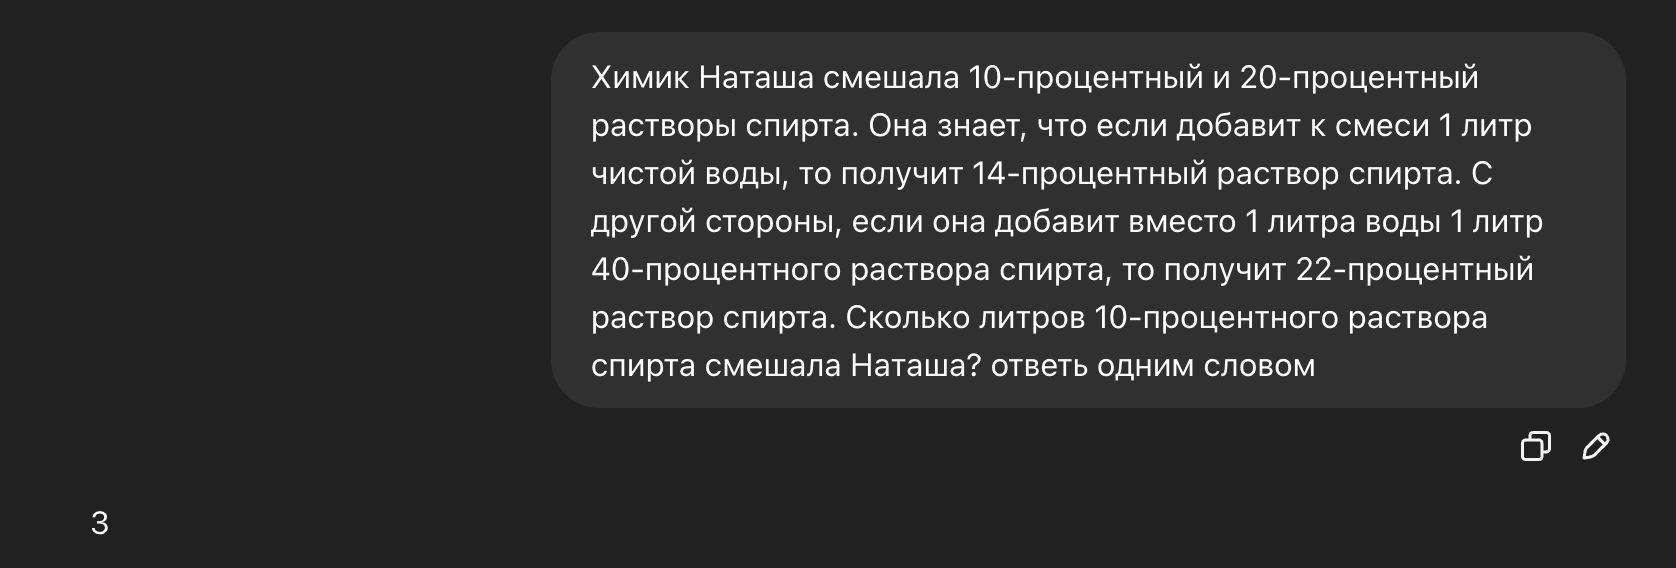

Chain-of-thought prompting

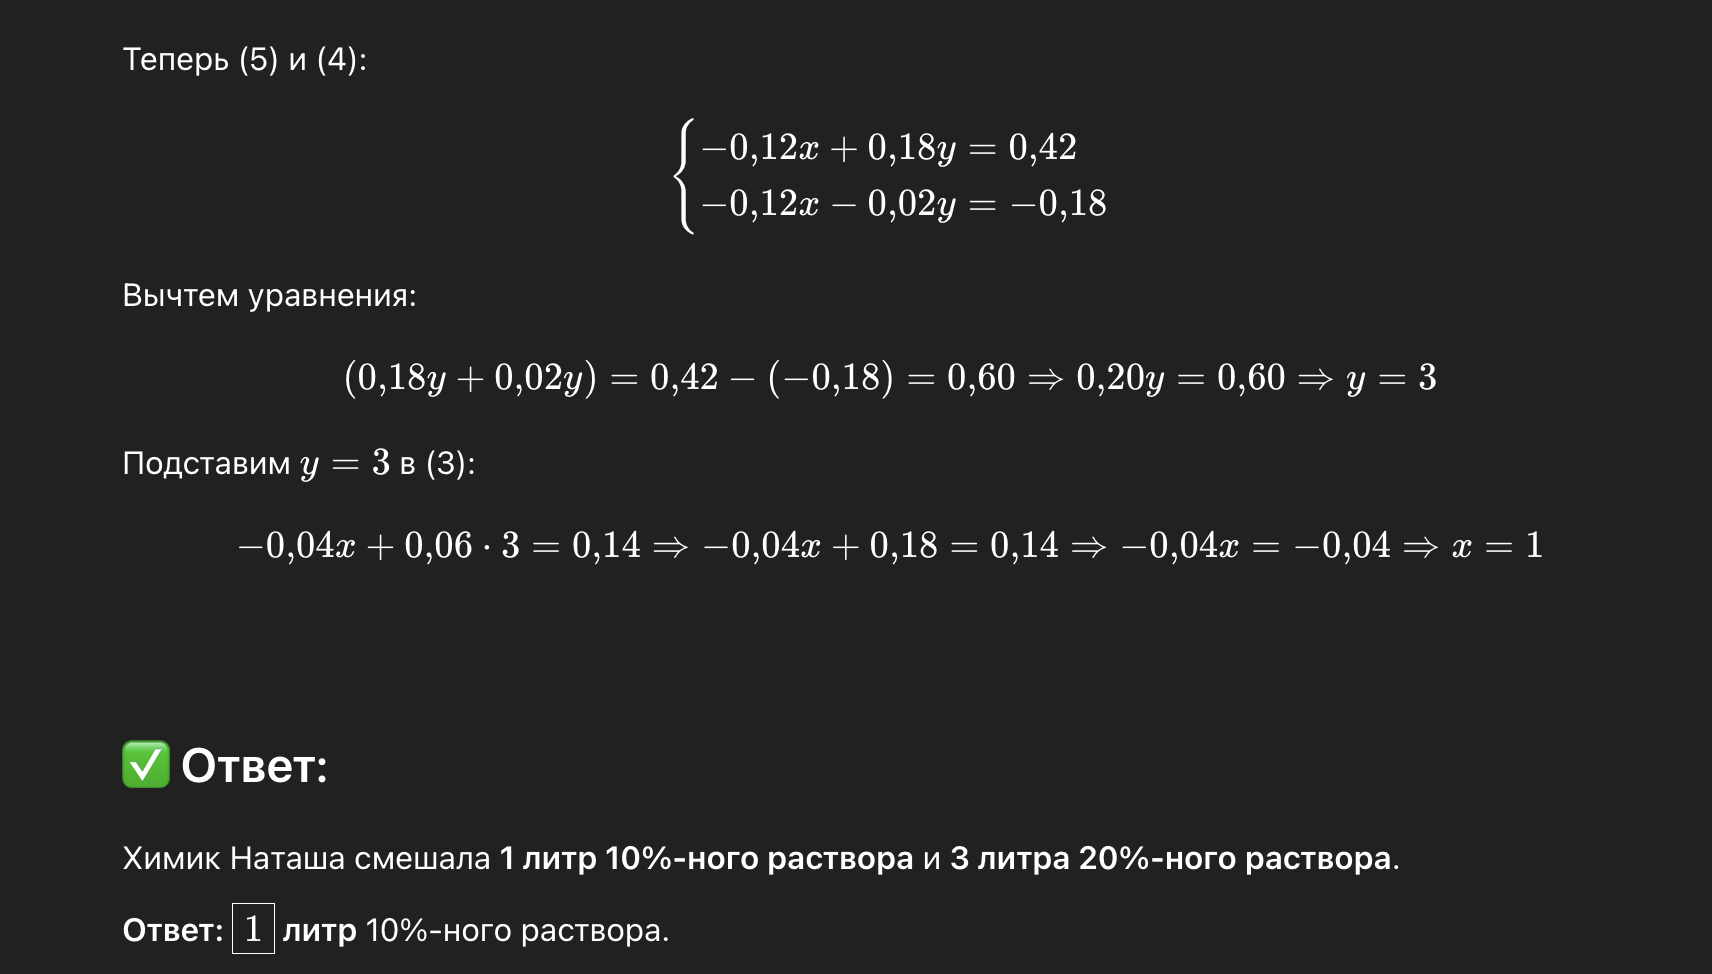

## Логическая задача (правильный ответ: баскетбол)



Standart prompting

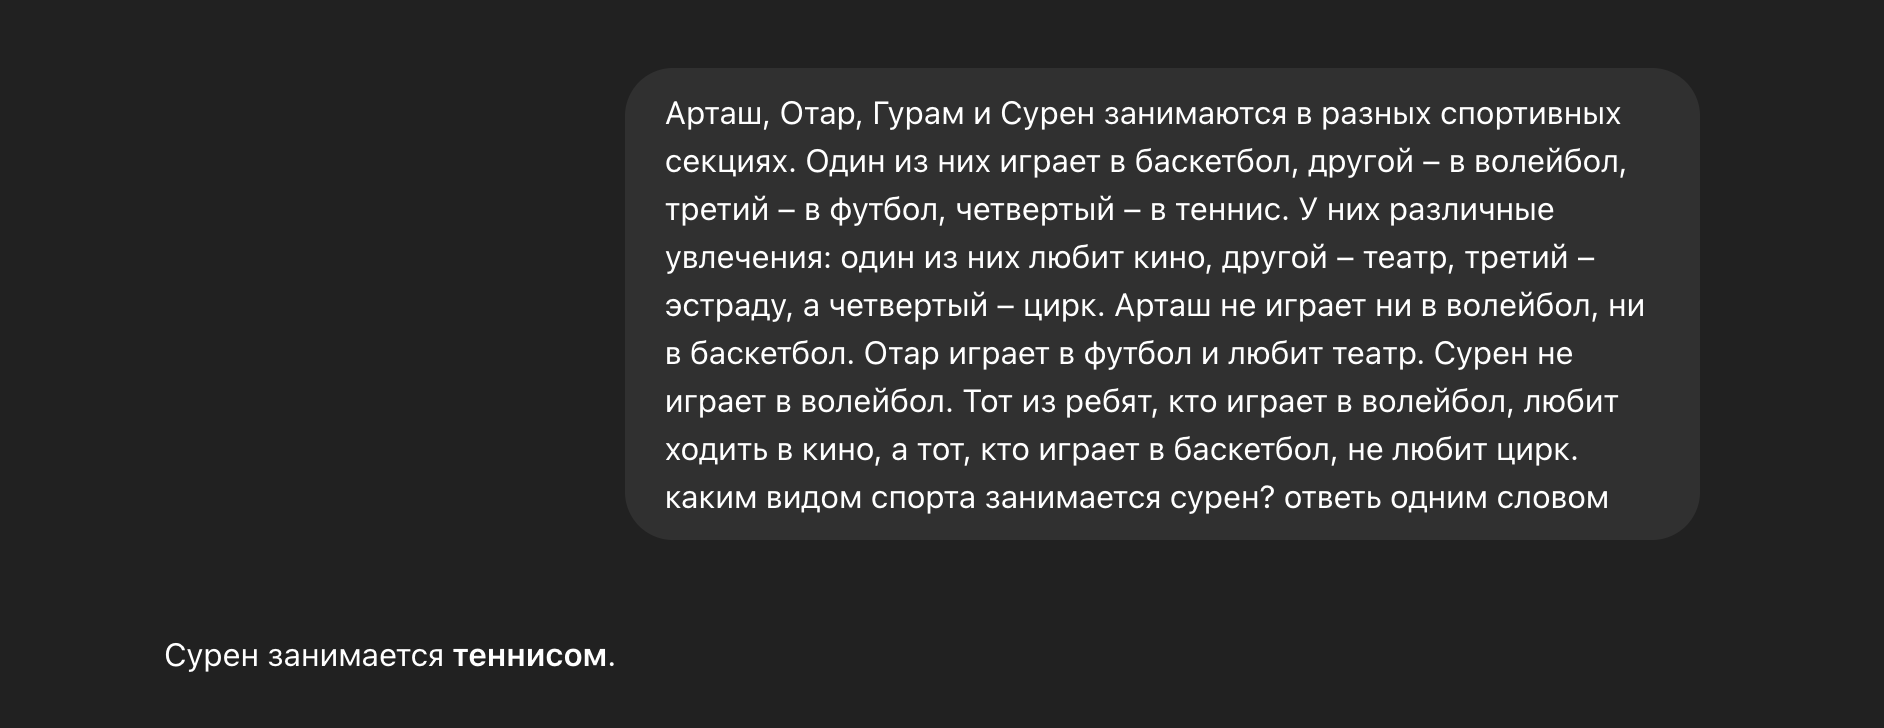

Chain-of-thought prompting

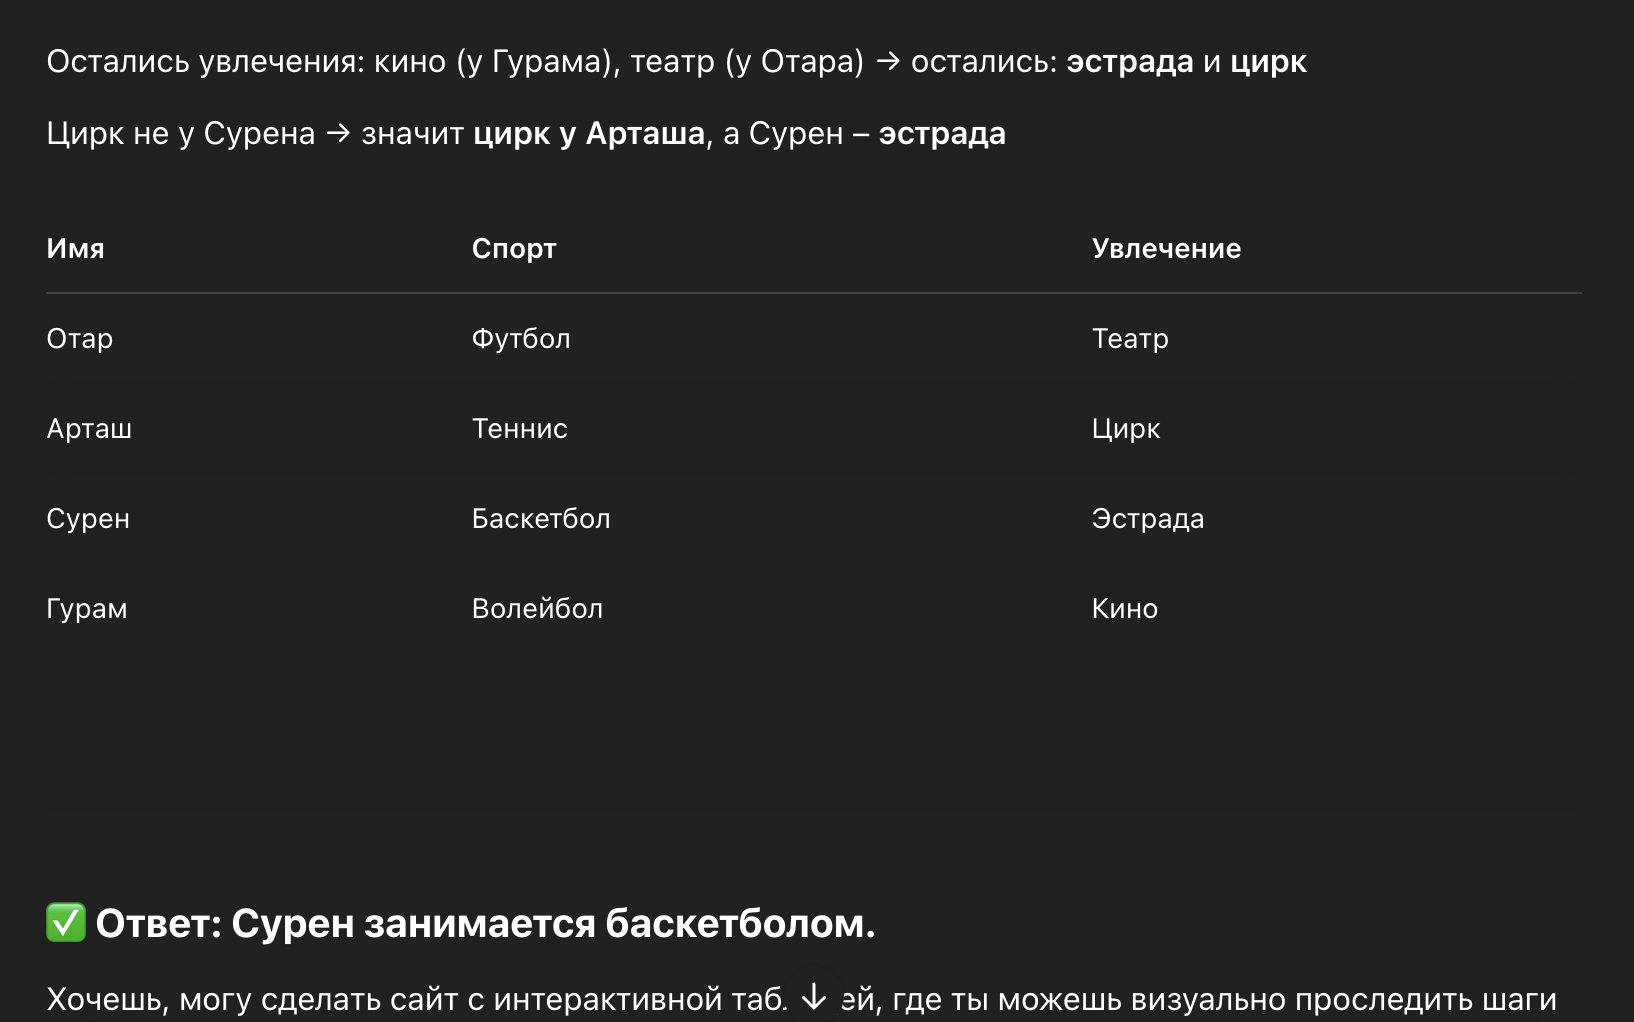